In [1]:
from matplotlib import pyplot as plt
import Functions_data_analysis as fda
import Functions_load_output as flo
import Functions_plotting as fp
from Datasets import exp_set_dict_warm_order
import numpy as np
import xarray as xr
from matplotlib import colors
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Use importlib to reload modules after editing them
import importlib
importlib.reload(fp)

<module 'Functions_plotting' from '/glade/campaign/univ/ulnl0002/Gemma/Analysis/Functions_plotting.py'>

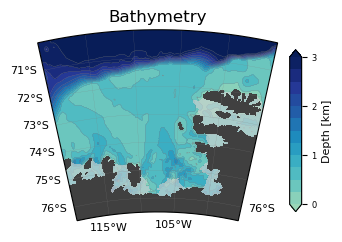

In [3]:
# Show locations of cross sections on bathymetry map
fp.plot_bathymetry_and_locs('AS_near', [])
plt.savefig('Plots/Figure_1a_bathymetry_map_simple.png',dpi=400)

In [4]:
# Retrieve ocean velocity data 

exp_set = 'ic_2001'
depth = -400 # (negative)
plot_region = 'AS_near'
# how many months of data to retrieve
month_start_idx = 0
n_months = 60

# retireve ensemble data
runs = exp_set_dict_warm_order[exp_set]
u_fname = 'Saved Arrays/Ensemble_data/U_'+exp_set+'_full_model_domain.nc'
v_fname = 'Saved Arrays/Ensemble_data/V_'+exp_set+'_full_model_domain.nc'
try:
    U_ds = xr.open_dataset(u_fname)
    all_run_U_da = U_ds.U
    V_ds = xr.open_dataset(v_fname)
    all_run_V_da = V_ds.V
    print('presaved data found')
except:
    all_run_U_da = fda.get_ensemble_data_for_ic('U', runs, region, 'state_3d_set2', month_start_idx = month_start_idx,
                                                n_months = n_months, depth=depth) 
    all_run_V_da = fda.get_ensemble_data_for_ic('V', runs, region, 'state_3d_set2', month_start_idx = month_start_idx,
                                                n_months = n_months, depth=depth) 
    # save data arrays
    U_ds = all_run_U_da.to_dataset(name='U')
    U_ds.to_netcdf(u_fname)
    V_ds = all_run_V_da.to_dataset(name='V')
    V_ds.to_netcdf(v_fname)
    print('new datasets saved:',u_fname,v_fname)

presaved data found


In [76]:
# Select regional data to match figure domain and calc run-mean and time-means
plot_region = 'AS_near'
lat1,lat2,lon1,lon2 = fda.plot_regions[plot_region]

# select region, average over all 5 years, calc ens mean
all_run_reg_U = all_run_U_da.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
all_run_U_yr1 = all_run_reg_U.isel(time=slice(0,12))
all_run_U_mean = all_run_U_yr1.mean(dim='time')
em_U = all_run_U_mean.mean(dim='run')

all_run_reg_V = all_run_V_da.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
all_run_V_yr1 = all_run_reg_V.isel(time=slice(0,12))
all_run_V_mean = all_run_V_yr1.mean(dim='time')
em_V = all_run_V_mean.mean(dim='run')

In [77]:
# Calculate magnitudes (maybe include...)

mag_em_levs = np.linspace(0,0.1,15)
mag_em = (em_U ** 2 + em_V ** 2) ** 0.5

# #mask small values and large values for plotting
# mask = (mag_em < 0.01) | (mag_em > 0.1) 
mask = (mag_em < 0.002) | (mag_em > 0.04) 
em_U_masked = em_U.where(~mask)
em_V_masked = em_V.where(~mask)

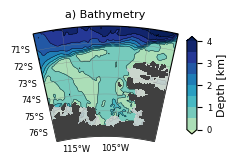

In [94]:
# Plot velocity quivers and bathymetry colors

# specify dataset to plot as quivers
data_x = em_U_masked
data_y = em_V_masked

# set up metadata
# title = 'a) 400m Depth Ens Mean Velocity'
title = 'a) Bathymetry'
vec_len = 0.03
fs = 8

# Set up plot
fig = plt.figure()
fig.set_size_inches((2.5,1.5))

# specify domain
lat1,lat2,lon1,lon2 = fda.plot_regions[plot_region]
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid)) 

# get bathymtery and ice ds
land_ice_ds = flo.get_bathymetry_and_troughs()
land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons, lats = land_ice_ds.lon, land_ice_ds.lat

# Plot bathymetry 
blevs = np.arange(0,4.25,0.5)
cmap_bupu = plt.get_cmap('YlGnBu')#BuPu
new_cmap = colors.ListedColormap(cmap_bupu(np.linspace(0.25, 1, 256)))
cf = ax.contourf(lons,lats,land_ice_ds.bathy/1000,blevs,transform=grid_proj,cmap=new_cmap,extend='both')
ax.contour(lons, lats, land_ice_ds.bathy/1000, blevs, colors='k',transform=grid_proj,linewidths=0.3,zorder=1)

# Plot ice
ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.8,zorder=4)
ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=4)

# plot quivers
q_lons, q_lats = data_x.lon, data_x.lat
# quiv = ax.quiver(q_lons, q_lats, data_x, data_y, transform = grid_proj, pivot = 'middle',
#                  regrid_shape=35, scale=.45, width=0.006, headwidth=2.5, headlength=5,
#                  color='k',edgecolor='white', linewidth = 0.02, zorder=3)
# quiv = ax.quiver(q_lons, q_lats, data_x, data_y, transform = grid_proj, pivot = 'middle',
#                  regrid_shape=20, scale=.3, width=0.006, headwidth=2.5, headlength=5,
#                  color='k',edgecolor='white', linewidth = 0.02, zorder=3)
# ax.quiverkey(quiv, X=0.97, Y=0.3, U=vec_len, label=str(vec_len)+'\nm/s', labelpos='S',
#              fontproperties={'size':8},zorder=2)

# Set shape of map to match shape of data rather than a rectangle
rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], 
                   [lon1, lat1], [lon1, lat2]]).interpolated(50)
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())
gl = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='-', linewidth=0.2,color='gray', 
                  xlocs=np.arange(-140,-60,5),
                  ylocs=np.arange(-76,-60,1),draw_labels=False,\
                  x_inline=False,y_inline=False,rotate_labels=False)
gl.left_labels = True
gl.bottom_labels=True
gl.top_labels=False
gl.right_labels=False
gl.xlabel_style = {'size': 6}
gl.ylabel_style = {'size': 6}

# add title and colorbar
plt.title(title, fontsize=8)
cb_ax = fig.add_axes([0.8,0.13,0.04,0.65])
cb_em = fig.colorbar(cf, cax=cb_ax, extend='both',orientation = 'vertical')  
cb_em.set_label(label = 'Depth [km]', fontsize=8)
cb_em.ax.tick_params(labelsize=6)
cb_em.set_ticks(blevs[0::2])

fig.subplots_adjust(left=0.1,right=0.85,top=0.85,bottom=0.08,wspace=0.1,hspace=.05)
plt.savefig('Plots/Figure_1a_bathy_simple.png',dpi=400)
# plt.savefig('Plots/Figure_1a_bathy_velocity.png',dpi=400)